# The HFM library - A fast marching solver with adaptive stencils

## Part : Seismology and crystallography
## Chapter : Generating cells of various anisotropies and sizes
$
\def\<{\langle}
\def\>{\rangle}
$

In this notebook, we illustrate how an eikonal solver can be use to partition a domain into random cells of various anisotropies and sizes. 

We essentially compute the generalized Appolonius diagram whose regions are defined as 
$$
    V_i = \{x \in \Omega | \forall j\in I, |x-x_i|_{M_i} + t_i < |x-x_j|_{M_j} + t_j \}
$$
where the domain $\Omega$, the points $x_i\in \Omega$, the matrices $M_i\in S_d^{++}$, and the times $t_i$ are given, for all $i$ in a finite set $I$. (Minor details differ, but this is the idea.) 
We also discuss the analogy with crystal growth, and the related annealing process.

This notebook is inspired by the talk entitled *Optimal transport problems in microstructure modelling* given by David Bourne at the workshop entitled *optimal transport theory and application to physics* Ecole de Physique de Houches. All inaccurracies mine.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. A crystalization model](#1.-A-crystalization-model)
  * [2. Annealing](#2.-Annealing)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

# 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless the package is installed)

In [2]:
import numpy as np; xp=np
from matplotlib import pyplot as plt

In [3]:
from agd import Metrics
from agd import Eikonal

### 0.1 Configuration

**Domain dimension.** The numerical experiments presented in this notebook are two dimensional, but could easily be extended to three dimensions. Change the constants below to test large cases.

In [4]:
seeds_n = 400 # Number of nucleation seed points 
Nx = 200 # Dimension of the grid (number of pixels on each side)
verbosity = 1 # Use 0 to silent output from the eikonal solver
#seeds_n = 40000; Nx = 2000 # Uncomment for larger test case

**GPU acceleration.** Unsupported for now. (The GPU solver does not compute Voronoi cells.)

<!---
Uncomment the following line to use the GPU eikonal solver, for instance if you use Google Colab (do not forget to require a GPU in the notebook settings). Note that, besides this solver, the rest of this notebook runs on the CPU.

Tag : EikonalGPU_config
#Eikonal.dictIn.default_mode = 'gpu_transfer'
--->

## 1. A crystalization model

We consider a material which is about to crystallize. At random times, and random points in the material, a crystallization process starts and propagates. 

In [5]:
np.random.seed(42)
vdim = 2 # vector space dimension
seeds_p = np.random.rand(vdim,seeds_n) # Position of the seeds (uniform in [0,1]^2)

# The n**(-1/d) scaling of the nucleation times avoids having too many empty regions,
# assuming a domain of diameter approx 1, and a propagation speed approx 1.
seeds_tmax = seeds_n**(-1/vdim) # Latest considered nucleation start time. 
seeds_t = seeds_tmax*np.random.rand(seeds_n) # Nucleation start time

seeds_f = np.arange(seeds_n) # Index used for the Voronoi diagram.
seeds_c = np.random.rand(seeds_n,3) # Color of each seed, uniform in [0,1]^3

seeds_data = {
    'number':seeds_n,
    'position':seeds_p,
    'time':seeds_t,
    'flag':seeds_f, 
    'color':seeds_c,
}

Crystallization is an anisotropic physical process, which reflects the atomic layout, and the crytal front starting at a given nucleation site is thus modeled has having unit speed w.r.t. a randomly chosen metric. 

For simplicity, we will randomly choose among a finite number of constant Riemannian metrics. 
Various alternative modeling choices could be considered here, possibly more physical, such as : 
* **crystalline** metrics, defined as $F(v) = \max_{p \in P} \<p,v\>$. However these metrics are currently not implemented in the AGD and the HFM solvers, but could be added quite easily. 
* **random rotations**, with uniformly distributed angle $\theta \in [0,2 \pi]$, for the nucleation sites. More generally, a different metric for each nucleation site. However using infinitely many classes of metrics, or a very large number of them, would make the numerical implementation below less efficient in the present form. (There are several optimization opportunities to make this work if needed.)

In [6]:
# Metrics dictate the nucleation front speed
metrics = [ 
    Metrics.Isotropic(2,vdim=2), # Cost given as input. Speed = 1/cost.
    Metrics.Diagonal([0.4,1]), # Cost along each axis given as input. 
    Metrics.Riemann.from_diagonal([0.4**2,1]).rotate_by(np.pi/3), # Cost**2 (!) along each axis given as input
]
metrics_n = len(metrics)

# Choose one metric, aka a crystallization mode, for each seed point
metrics_p = [4.,1.,1.] # Define the relative probability of each metric
metrics_p=np.array(metrics_p)/np.sum(metrics_p) # Normalization of probabilities
flags_m = np.random.choice(range(metrics_n),1+np.max(seeds_f), p=metrics_p)

seeds_data.update({
    'flag_metric':flags_m,
    'metric_data':metrics,
})

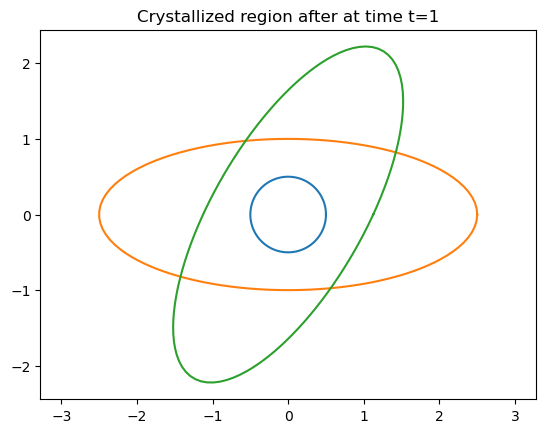

In [7]:
θs = np.linspace(0,2*np.pi,200)
unitvecs = np.array([np.cos(θs),np.sin(θs)])
plt.title("Crystallized region after at time t=1")
plt.axis('equal')
for metric in metrics:
    plt.plot(*unitvecs/metric.norm(unitvecs))

We run the fast marching once for each metric, since the library cannot dynamically switch between different metrics depending on e.g. the closest seed point.

In [8]:
def imshow(im,ax=plt):
    """Show an image with an axes convention compatible with plt.scatter"""
    ax.imshow(im.swapaxes(0,1),origin='lower')

Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.009355 s.
Field exportVoronoiFlags defaults to 1
Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.008696 s.
Field exportVoronoiFlags defaults to 1
Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.015552 s.
Field exportVoronoiFlags defaults to 1


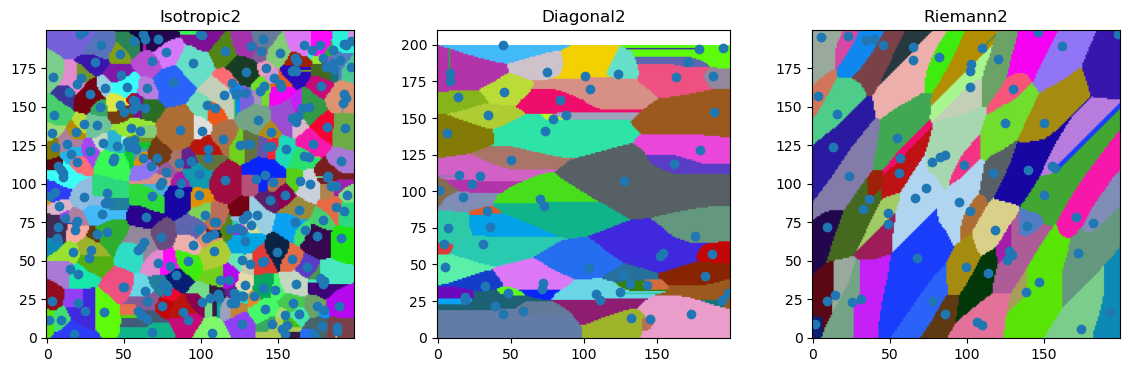

In [9]:
fig, axs = plt.subplots(figsize=[14,4],ncols=metrics_n)
for m,(metric,ax) in enumerate(zip(metrics,axs)):
    which = (flags_m[seeds_f] == m)
    eikIn = Eikonal.dictIn({
        'metric':metric,
        'model':metric.model_HFM(),
        'seeds':seeds_p[:,which].T,
        'seedValues':seeds_t[which],
        'seedFlags':seeds_f[which],
        'dims':(Nx,Nx),
        'gridScale':1/Nx,
        'exportValues':True,
        'verbosity':verbosity,
    })
    eikOut = eikIn.Run()
    
    vor = eikOut['voronoiFlags'].astype(int)
    imshow(seeds_c[vor],ax)
    ax.scatter(*eikIn['seeds'].T*Nx)
    ax.set_title(metric.model_HFM())

In order to get a usable result, we need to merge the three Voronoi diagrams into a single one.
We bundle this into a function.

In [10]:
def crystal_regions(seeds_data):
    seeds_n,seeds_p,seeds_t,seeds_f,flag_m,metrics = [
        seeds_data[e] for e in ('number','position','time','flag','flag_metric','metric_data')]
    
    def make_eikIn(metric,which):
        """Prepare the input of the fast marching method"""
        return Eikonal.dictIn({
            'metric':metric,
            'model':metric.model_HFM(),
            'seeds':seeds_p[:,which].T,
            'seedValues':seeds_t[which],
            'seedFlags':seeds_f[which],
            'dims':(Nx,Nx),
            'gridScale':1/Nx,
            'exportValues':True,
            'verbosity':verbosity,
        })    
    
    vors = []
    vals = []
    for m,metric in enumerate(metrics):
        which = (flag_m[seeds_f] == m)
        eikIn = make_eikIn(metric,which)
        eikOut = eikIn.Run()
        
        vors.append(eikOut['voronoiFlags'].astype(int))
        vals.append(eikOut['values'])
    
    # Merge the Voronoi regions, using the minimal distance
    val = np.min(vals,axis=0) # Voronoi regions are defined by the smallest arrival time
    active = np.argmin(vals,axis=0) 
    vor = np.take_along_axis(np.array(vors),active[None],axis=0).squeeze(axis=0)
    
    # Find the boundaries of the regions 
    bd = np.full_like(vor,False,dtype=bool)
    for i in range(vor.ndim):
        bd |= np.roll(vor, 1,axis=i)!=vor
        bd |= np.roll(vor,-1,axis=i)!=vor
            
    return {'vor':vor,'val':val,'vors':vors,'vals':vals,'bd':bd,'metric_index':flag_m[vor]}

In [11]:
crystal_data = crystal_regions(seeds_data)

Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.009339 s.
Field exportVoronoiFlags defaults to 1
Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.008718 s.
Field exportVoronoiFlags defaults to 1
Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.015698 s.
Field exportVoronoiFlags defaults to 1


We can see, as desired, many small isotropic regions, a number of large horizontal regions, and a number of large tilted regions, corresponding to the three crystallization modes.

**Note on a bug/artifact related to empty regions.**
The HFM library freezes values associated with seed points. For the present application, this is a bit annoying and unphysical. It means that if a region is crystallized at some time, but a nucleation site needs to appear at a later time, then the site is not rejected but instead exists on the scale of a single pixel.

Note however that it would not be hard to weed out these single isolated pixels using a suitable post-processing step. In addition, they are 'melted' anyway in the annealing process described in the next section.


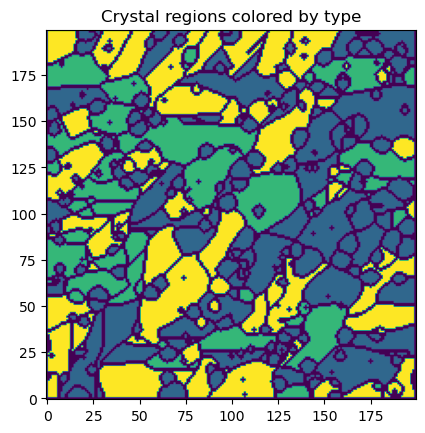

In [12]:
plt.title("Crystal regions colored by type")
imshow( np.where(crystal_data['bd'],-1,crystal_data['metric_index']) )

## 2. Annealing

The process described above generates many very small regions. 
In order to have a smaller set of larger regions, with more consistent sizes, we can implement the process of annealing : 
- melt the boundaries of the regions.
- restart crystallization from the non-melted parts of the domain.

In [13]:
def merge_metrics(metric_data,metric_index):
    """Merge different metrics into a common (Riemannian) one."""
    ind = metric_index
    merged = np.full((ind.ndim,ind.ndim)+ind.shape,np.nan) # Merged Riemannian tensor
    for m,metric in enumerate(metric_data):
        merged[:,:,ind==m] = Metrics.Riemann.from_cast(metric).m[:,:,None]
    return Metrics.Riemann(merged)

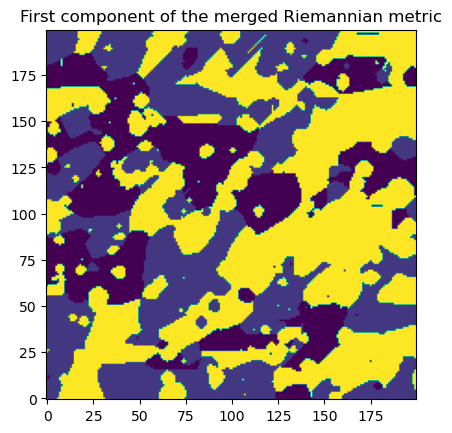

In [14]:
mtest = merge_metrics(seeds_data['metric_data'], crystal_data['metric_index'])
plt.title("First component of the merged Riemannian metric")
imshow(mtest.m[0,0])

In [15]:
def melt(seeds_data,crystal_data,melt_metric,melt_time):
    """Returns the melting time of the different points in the domain, 
    assuming melting starts from the domain boundaries"""
    
    # Compute the melted region
    seeds = (np.array(crystal_data['bd'].nonzero())+0.5)/Nx # Seeds on the boundaries of the regions
    eikIn = Eikonal.dictIn({
        'metric':melt_metric,
        'model':melt_metric.model_HFM(),
        'dims':(Nx,Nx),
        'gridScale':1/Nx,
        'seeds':seeds.T,
        'exportValues':True,
        'verbosity':verbosity,
    })
    eikOut = eikIn.Run()
    melted = eikOut['values']<melt_time
    intact = np.logical_not(melted)
    
    # Generate the new seed data
    seeds_n2 = np.sum(intact)
    seeds_data2 = {
        'number':seeds_n2,
        'position': (np.array(intact.nonzero())+0.5)/Nx, # Seeds everywhere in the intact region
        'time':np.zeros(seeds_n2),
        'flag': crystal_data['vor'][intact],
        'flag_metric': seeds_data['flag_metric'],
        'metric_data':seeds_data['metric_data'],
    }
    return {'melted':melted,'eikOut':eikOut,'seeds_data2':seeds_data2}

We assume here that the **crystals melt as fast as they grow**.

In [16]:
melt_metric = merge_metrics(seeds_data['metric_data'], crystal_data['metric_index'])
melt_data = melt(seeds_data,crystal_data,melt_metric,0.2*seeds_tmax)

Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009496 s.


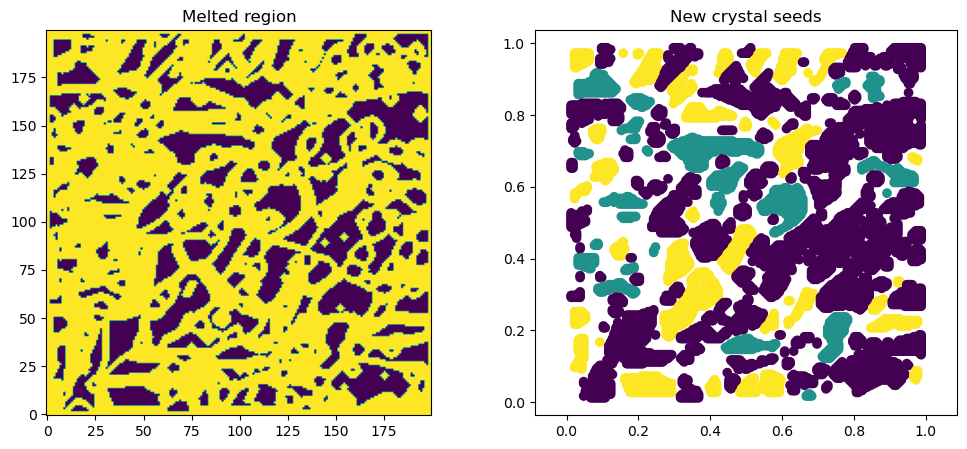

In [17]:
fig,(ax0,ax1) = plt.subplots(figsize=[12,5],ncols=2)

ax0.set_title("Melted region")
imshow(melt_data['melted'],ax0)

ax1.set_title("New crystal seeds")
s2 = melt_data['seeds_data2']
ax1.scatter(*s2['position'],c=s2['flag_metric'][s2['flag']]) 
ax1.axis('equal');

Let us regrow the crystal from the new seeds.

In [18]:
crystal_data2 = crystal_regions(melt_data['seeds_data2'])

Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.007702 s.
Field exportVoronoiFlags defaults to 1
Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.00811 s.
Field exportVoronoiFlags defaults to 1
Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.014274 s.
Field exportVoronoiFlags defaults to 1


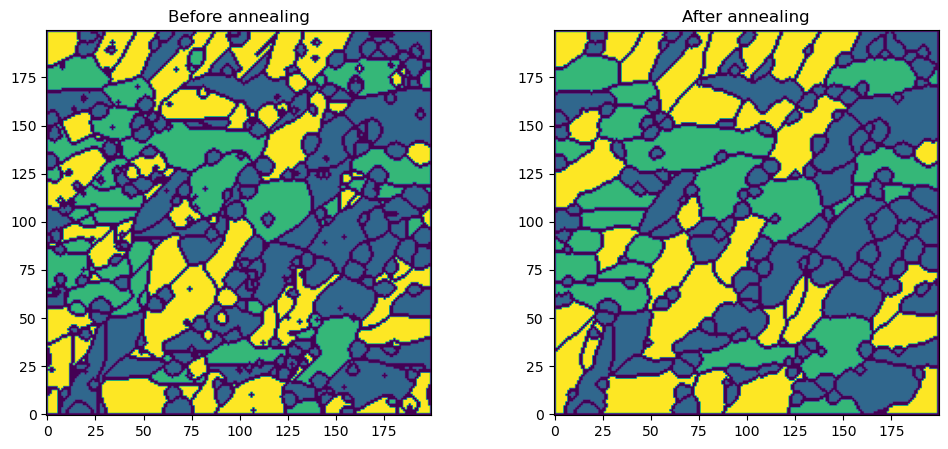

In [19]:
fig, (ax0,ax1) = plt.subplots(figsize=[12,5],ncols=2)
ax0.set_title("Before annealing")
imshow( np.where(crystal_data['bd'],-1,crystal_data['metric_index']),ax0 )
ax1.set_title("After annealing")
imshow( np.where(crystal_data2['bd'],-1,crystal_data2['metric_index']),ax1 )

Alternatively, we can assume that *the melting process has the same speed for all crystal types*.

In [20]:
melt_metric = metrics[0] # The melting metric
melt_data = melt(seeds_data,crystal_data,melt_metric,0.4*seeds_tmax)

Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.006735 s.


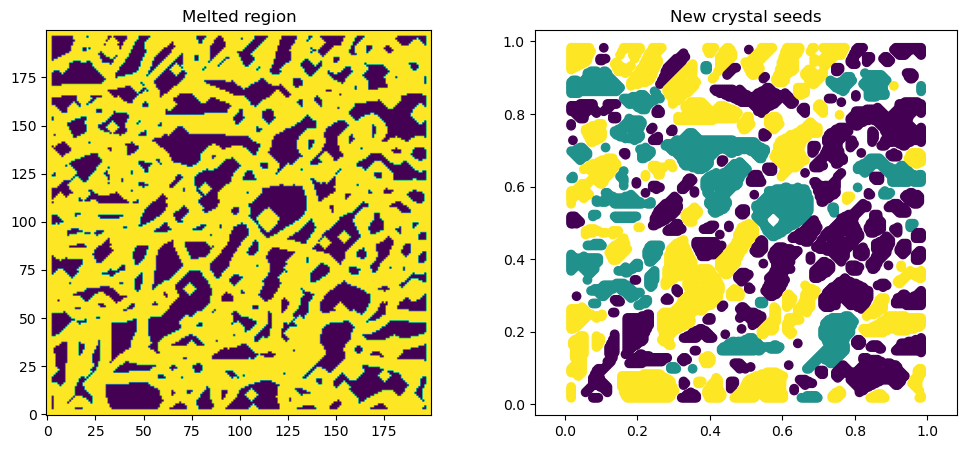

In [21]:
fig,(ax0,ax1) = plt.subplots(figsize=[12,5],ncols=2)

ax0.set_title("Melted region")
imshow(melt_data['melted'],ax0)

ax1.set_title("New crystal seeds")
s2 = melt_data['seeds_data2']
ax1.scatter(*s2['position'],c=s2['flag_metric'][s2['flag']]) 
ax1.axis('equal');

In [22]:
crystal_data2 = crystal_regions(melt_data['seeds_data2'])

Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.008136 s.
Field exportVoronoiFlags defaults to 1
Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.008046 s.
Field exportVoronoiFlags defaults to 1
Field origin defaults to {0,0}
Field order defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.013899 s.
Field exportVoronoiFlags defaults to 1


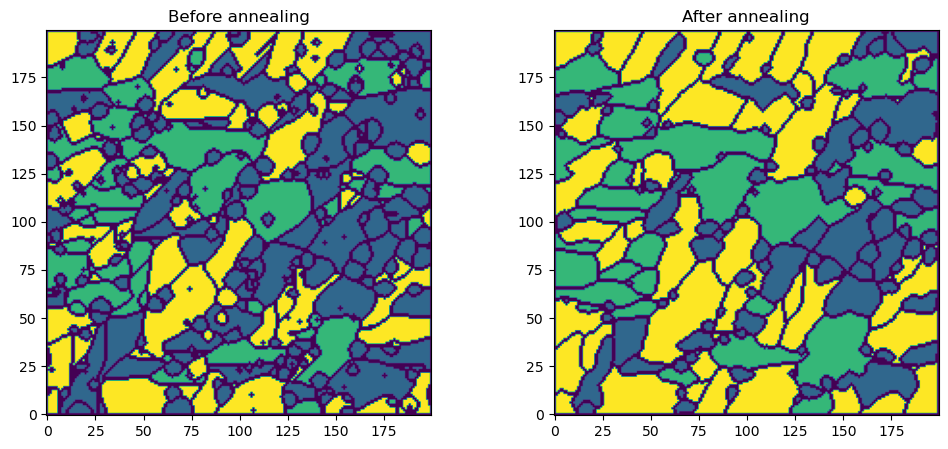

In [23]:
fig, (ax0,ax1) = plt.subplots(figsize=[12,5],ncols=2)
ax0.set_title("Before annealing")
imshow( np.where(crystal_data['bd'],-1,crystal_data['metric_index']),ax0 )
ax1.set_title("After annealing")
imshow( np.where(crystal_data2['bd'],-1,crystal_data2['metric_index']),ax1 )